In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys
from os.path import join,expanduser
import glob

user_home_dir = expanduser('~')
sys.path.append(join(user_home_dir,'Documents','py_functions'))
sys.path.append(join(user_home_dir,'Documents','Sea_level'))

from filter_functions import *
from stat_functions import *
from tseries_ref_load import tseries_reference,gmsl_sat_read

In [4]:
# open grid parameters file
grid_file = glob.glob(join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC','*GEOMETRY*','*.nc'))[0]
ds_grid = xr.open_dataset(grid_file)

year_first = 1993
year_last = 2017

year_range_id = str(year_first)+'_'+str(year_last)


# ECCO state estimate SSH
ds_ECCO_v4r4 = xr.open_mfdataset(join(expanduser('~'),'Downloads','ECCO_V4r4_PODAAC',\
                                          'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4','*llc0090.nc'),\
                                     compat='override',data_vars='minimal',coords='minimal')
time_v4r4_ind = np.logical_and(ds_ECCO_v4r4.time.values >= np.datetime64(str(year_first)+'-01-01','ns'),\
                               ds_ECCO_v4r4.time.values < np.datetime64(str(year_last+1)+'-01-01','ns'))\
                                .nonzero()[0]
wet_gridcell_area = ds_grid.hFacC.isel(k=0)*ds_grid.rA
SSH_rel_v4r4 = ds_ECCO_v4r4.SSH - ((wet_gridcell_area*ds_ECCO_v4r4.SSH).sum(['tile','j','i'])\
                                   /(wet_gridcell_area.sum(['tile','j','i'])))
SSH_rel_v4r4 = SSH_rel_v4r4.isel(time=time_v4r4_ind)
v4r4_time = SSH_rel_v4r4.time.values

# spatially subset v4r4 and grid file
subset_dict = {'tile':10,'j':slice(28,50),'j_g':slice(28,51),'i':slice(60,85),'i_g':slice(60,86)}
ds_grid = ds_grid.isel(subset_dict)
SSH_rel_v4r4 = SSH_rel_v4r4.isel({dim:subset_dict[dim] for dim in ['tile','j','i']})



def data_llcshape(data):
    "Shape output into 13 tiles configuration"
    len_j_i = 90    # length of each side of tile
    n_nonspat = int(data.size/(13*(len_j_i**2)))
    
    data_shaped = np.reshape(data,(n_nonspat,13,len_j_i,len_j_i))
    ind_tile7start = np.reshape(np.arange(7*(len_j_i**2),data.size,13*(len_j_i**2)),(-1,1))
    ind_tile10start = np.reshape(np.arange(10*(len_j_i**2),data.size,13*(len_j_i**2)),(-1,1))
    ind_tile7to9 = (ind_tile7start + np.arange(0,3*(len_j_i**2))).flatten()
    ind_tile10to12 = (ind_tile10start + np.arange(0,3*(len_j_i**2))).flatten()
    data_shaped[:,7:10,:,:] = np.moveaxis(np.reshape(data[ind_tile7to9],(n_nonspat,len_j_i,3,len_j_i)),-2,-3)
    data_shaped[:,10:13,:,:] = np.moveaxis(np.reshape(data[ind_tile10to12],(n_nonspat,len_j_i,3,len_j_i)),-2,-3)
    
    return data_shaped


# read regional mask file
adj_sens_loc = 'EasternGulfCoast'
mask_filename = join(user_home_dir,'Downloads','ECCO_v4r4_adjoint','adjoint_sensitivities',adj_sens_loc,\
                     'mask_'+adj_sens_loc+'.bin')
mask = np.fromfile(mask_filename,dtype='>f4')
mask_EGC = xr.DataArray(data_llcshape(mask).squeeze(),dims=['tile','j','i'])
mask_EGC = mask_EGC.isel({dim:subset_dict[dim] for dim in ['tile','j','i']}).values

adj_sens_loc = 'WesternGulfCoast'
mask_filename = join(user_home_dir,'Downloads','ECCO_v4r4_adjoint','adjoint_sensitivities',adj_sens_loc,\
                     'mask_'+adj_sens_loc+'.bin')
mask = np.fromfile(mask_filename,dtype='>f4')
mask_WGC = xr.DataArray(data_llcshape(mask).squeeze(),dims=['tile','j','i'])
mask_WGC = mask_WGC.isel({dim:subset_dict[dim] for dim in ['tile','j','i']}).values

In [5]:
file_obs_alt_gridded = join(expanduser('~'),'Downloads','Altimetry',\
                                          'MEASURES','2205','MEASURES_tseries_1993_2022.nc')
file_gmsl_sat_era = join(expanduser('~'),'Downloads','GMSL','MERGED_TP_J1_OSTM_OST_GMSL_ASCII_V51',\
                        'GMSL_TPJAOS_5.1.txt')
file_gmsl_pre_sat = join(expanduser('~'),'Downloads','GMSL','JPL_RECON_GMSL','global_timeseries_measures.nc')

ds_altim = xr.open_mfdataset(file_obs_alt_gridded)
# subset to smaller domain and load into memory
ds_altim = ds_altim.isel(lat=slice(560,700),lon=slice(1540,1730)).compute()
gmsl_fields = gmsl_sat_read(file_gmsl_sat_era)
da_gmsl_sat_era = xr.DataArray(gmsl_fields[3],dims=['time'],coords={'time':gmsl_fields[0]})


gmsl_in_time_range = np.array([])
for curr_datetime in ds_altim.time.values:
    curr_tbin_start = curr_datetime.astype('datetime64[M]').astype('datetime64[ns]')
    curr_tbin_end = (curr_datetime.astype('datetime64[M]') + np.timedelta64(1,'M')).astype('datetime64[ns]')
    curr_gmsl_sat_ind = np.logical_and(da_gmsl_sat_era.time.values >= curr_tbin_start,\
                                       da_gmsl_sat_era.time.values < curr_tbin_end).nonzero()[0]
    gmsl_in_time_range = np.append(gmsl_in_time_range,\
                                  np.nanmean(da_gmsl_sat_era[curr_gmsl_sat_ind]))
gmsl_in_time_range = xr.DataArray(gmsl_in_time_range,dims=['time'],coords={'time':ds_altim.time.values})

SSH_rel = ds_altim.ssh - gmsl_in_time_range

In [6]:
# wet mask in altimetry data
alt_wet_mask = ~np.isnan(SSH_rel[100,:,:].values)

SSH_rel_values = SSH_rel.values

time_altim_ind = np.logical_and(SSH_rel.time.values >= np.datetime64(str(year_first)+'-01-01','ns'),\
                                SSH_rel.time.values < np.datetime64(str(year_last+1)+'-01-01','ns'))\
                                    .nonzero()[0]
SSH_rel_values_inrange = SSH_rel_values[time_altim_ind,:,:]

altim_lon_bounds = ds_altim.lon[:-1].values + np.diff((((ds_altim.lon.values + 180) % 360) - 180)/2)
altim_lon_bounds = np.nanmin(altim_lon_bounds) + ((altim_lon_bounds - np.nanmin(altim_lon_bounds)) % 360)
altim_lat_bounds = ds_altim.lat[:-1].values + np.diff(ds_altim.lat.values/2)

altim_llc90 = np.empty((SSH_rel_v4r4.shape[0],SSH_rel_v4r4.sizes['j'],SSH_rel_v4r4.sizes['i']))
for j in range(0,SSH_rel_v4r4.sizes['j']):
    curr_ECCO_lon_min = ds_grid.XG[j,12].values
    curr_ECCO_lon_max = ds_grid.XG[1+j,12].values
    in_ECCO_alt_i = ((altim_lon_bounds - curr_ECCO_lon_min) % 360\
                     < (curr_ECCO_lon_max - curr_ECCO_lon_min)).nonzero()[0]
    curr_altim_lon_bounds = np.concatenate((np.array([curr_ECCO_lon_min]),\
                                            altim_lon_bounds[in_ECCO_alt_i],\
                                            np.array([curr_ECCO_lon_max])))
    curr_altim_lon_bounds = curr_ECCO_lon_min + ((curr_altim_lon_bounds - curr_ECCO_lon_min) % 360)
    in_ECCO_alt_i = np.append(in_ECCO_alt_i,np.nanmax(in_ECCO_alt_i)+1)
    weight_i = np.diff(curr_altim_lon_bounds)/np.nansum(np.diff(curr_altim_lon_bounds))
    for i in range(0,SSH_rel_v4r4.sizes['i']):
        if ds_grid.hFacC.isel(k=0,j=j,i=i).values <= 0.5:
            continue
        curr_ECCO_lat_min = ds_grid.YG[11,1+i].values
        curr_ECCO_lat_max = ds_grid.YG[11,i].values
        in_ECCO_alt_j = np.logical_and(altim_lat_bounds >= curr_ECCO_lat_min,\
                                       altim_lat_bounds < curr_ECCO_lat_max).nonzero()[0]
        curr_altim_lat_bounds = np.concatenate((np.array([curr_ECCO_lat_min]),\
                                                altim_lat_bounds[in_ECCO_alt_j],\
                                                np.array([curr_ECCO_lat_max])))
        curr_altim_lat_centers = curr_altim_lat_bounds[:-1] + (np.diff(curr_altim_lat_bounds)/2)
        in_ECCO_alt_j = np.append(in_ECCO_alt_j,np.nanmax(in_ECCO_alt_j)+1)
        weight_j = np.diff(curr_altim_lat_bounds)/np.nansum(np.diff(curr_altim_lat_bounds))
        weights = np.reshape(weight_j*np.cos((np.pi/180)*curr_altim_lat_centers),(-1,1))*weight_i
        weights = weights*alt_wet_mask[np.reshape(in_ECCO_alt_j,(-1,1)),in_ECCO_alt_i]
        weights = weights/np.nansum(weights)
        
        altim_llc90[:,j,i] = np.nansum(np.nansum(np.expand_dims(weights,axis=0)\
                                    *SSH_rel_values_inrange[:,np.reshape(in_ECCO_alt_j,(-1,1)),in_ECCO_alt_i],axis=-2),axis=-1)

In [8]:
# loading tide gauge data

# tide gauge locations and IDs
tidegauge_lon = {'Key West': -81.808, 'Fort Myers': -81.872, 'St. Petersburg': -82.627, 'Cedar Key': -83.032,\
                 'Apalachicola': -84.98, 'Pensacola': -87.212, 'Grand Isle': -89.957, 'Galveston': -94.793,\
                 'Rockport': -97.047, 'Port Isabel': -97.215}
tidegauge_lat = {'Key West': 24.555, 'Fort Myers': 26.648, 'St. Petersburg': 27.762, 'Cedar Key': 29.135,\
                 'Apalachicola': 29.725, 'Pensacola': 30.405, 'Grand Isle': 29.263, 'Galveston': 29.31,\
                 'Rockport': 28.022, 'Port Isabel': 26.062}
tidegauge_psmsl_id = {'Key West': 188, 'St. Petersburg': 520, 'Pensacola': 246, 'Grand Isle': 526,\
                      'Galveston': 161, 'Port Isabel': 497}

tgauge_all_tseries = np.empty((SSH_rel_v4r4.sizes['time'],len(tidegauge_psmsl_id)))
tgauge_all_tseries.fill(np.nan)
SSH_rel_v4r4_at_tgauge_all = np.empty((SSH_rel_v4r4.sizes['time'],len(tidegauge_psmsl_id)))
SSH_rel_v4r4_at_tgauge_all.fill(np.nan)
for tgauge_count,place_id in enumerate(tidegauge_psmsl_id.keys()):
    lat_pt = tidegauge_lat[place_id]
    lon_pt = tidegauge_lon[place_id]
    psmsl_id = tidegauge_psmsl_id[place_id]

    # # ERA5 monthly mean SLP (for IB correction)
    file_slp_monthly = join(user_home_dir,'Downloads','ERA5','monthly','ERA5_mon_swind_slp_1950_2023.nc')
    
    
    # # tide gauge data file (text file)
    tgauge_obs_filename = join(expanduser('~'),'Documents','Sea_level','2022_ecco_predict','Data',\
                               str(psmsl_id)+'.rlrdata')

    tseries_ref_kwargs = {'lat_pt':lat_pt,'lon_pt':lon_pt,'psmsl_id':psmsl_id,\
                          'file_slp_monthly':file_slp_monthly,\
                          'file_gmsl_sat_era':file_gmsl_sat_era,\
                          'file_gmsl_pre_sat':file_gmsl_pre_sat,\
                          'tgauge_obs_filename':tgauge_obs_filename}

    ref_outputs = tseries_reference('obs_tgauge',np.arange(1993,2018),\
                                             **tseries_ref_kwargs)
    tgauge_tseries,tgauge_datetime = ref_outputs[:2]

    if len(tgauge_tseries) != (25*12):
        import pdb
        pdb.set_trace()

    closest_j,closest_i = np.unravel_index(\
                                            np.nanargmin(np.abs((np.cos((np.pi/180)*lat_pt)\
                                              *(((ds_grid.XC.where(ds_grid.hFacC.isel(k=0) > 0.5,np.nan).values - lon_pt + 180) % 360) - 180))\
                                              + (1j*(ds_grid.YC.where(ds_grid.hFacC.isel(k=0) > 0.5,np.nan).values - lat_pt)))),ds_grid.XC.shape)
    closest_v4r4_tseries = SSH_rel_v4r4.isel(j=closest_j,i=closest_i).values

    tgauge_all_tseries[:,tgauge_count] = tgauge_tseries
    SSH_rel_v4r4_at_tgauge_all[:,tgauge_count] = closest_v4r4_tseries

In [14]:
def seas_cycle_remove(tseries,time,time_axis_num=-1):
    tseries_noseason = seasonal_cycle_harmonics(tseries,time,num_harmonics=4,time_axis_num=time_axis_num)
    
    return tseries_noseason


def trendline_10yrlp_compute(tseries,time_axis_num=-1,edge_handling_opt=1):
    tseries_lp,trendline = bandpass_err_fcn(tseries,axis=time_axis_num,delta_dim=365.24/12,\
                                            high_bound=1/(10*365.24),steepness_factor=2,\
                                            trend_handling_opt=1,edge_handling_opt=edge_handling_opt)
    
    return tseries_lp,trendline


def trendline_12molp_compute(tseries,time_axis_num=-1,edge_handling_opt=1):
    tseries_lp,trendline = bandpass_err_fcn(tseries,axis=time_axis_num,delta_dim=365.24/12,\
                                            high_bound=1/365.24,steepness_factor=2,\
                                            trend_handling_opt=1,edge_handling_opt=edge_handling_opt)
    
    return tseries_lp,trendline


altim_llc90_noseas = seas_cycle_remove(altim_llc90,v4r4_time,time_axis_num=0)
tgauge_all_noseas = seas_cycle_remove(tgauge_all_tseries,v4r4_time,time_axis_num=0)
v4r4_noseas = seas_cycle_remove(SSH_rel_v4r4.values,v4r4_time,time_axis_num=0)
v4r4_at_tgauge_noseas = seas_cycle_remove(SSH_rel_v4r4_at_tgauge_all,v4r4_time,time_axis_num=0)

altim_llc90_10yrlp,altim_trendline = trendline_10yrlp_compute(altim_llc90_noseas,time_axis_num=0,edge_handling_opt=0)
tgauge_all_10yrlp,tgauge_all_trendline = trendline_10yrlp_compute(tgauge_all_noseas,time_axis_num=0,edge_handling_opt=0)
v4r4_10yrlp,v4r4_trendline = trendline_10yrlp_compute(v4r4_noseas,time_axis_num=0,edge_handling_opt=0)
v4r4_at_tgauge_10yrlp,v4r4_at_tgauge_trendline = trendline_10yrlp_compute(v4r4_at_tgauge_noseas,time_axis_num=0,edge_handling_opt=0)

altim_llc90_12molp,_ = trendline_12molp_compute(altim_llc90_noseas,time_axis_num=0,edge_handling_opt=0)
tgauge_all_12molp,_ = trendline_12molp_compute(tgauge_all_noseas,time_axis_num=0,edge_handling_opt=0)
v4r4_12molp,_ = trendline_12molp_compute(v4r4_noseas,time_axis_num=0,edge_handling_opt=0)
v4r4_at_tgauge_12molp,_ = trendline_12molp_compute(v4r4_at_tgauge_noseas,time_axis_num=0,edge_handling_opt=0)

altim_llc90_subannual = altim_llc90_noseas - altim_llc90_12molp
tgauge_all_subannual = tgauge_all_noseas - tgauge_all_12molp
v4r4_subannual = v4r4_noseas - v4r4_12molp
v4r4_at_tgauge_subannual = v4r4_at_tgauge_noseas - v4r4_at_tgauge_12molp

altim_llc90_interannual = altim_llc90_12molp - altim_llc90_10yrlp
tgauge_all_interannual = tgauge_all_12molp - tgauge_all_10yrlp
v4r4_interannual = v4r4_12molp - v4r4_10yrlp
v4r4_at_tgauge_interannual = v4r4_at_tgauge_12molp - v4r4_at_tgauge_10yrlp

In [27]:
corr_subannual_all = correlation_scalar_scalar_uncert(v4r4_subannual,altim_llc90_subannual,\
                                                        axis=0,confidence_level=0.95)
corr_subannual = corr_subannual_all[0][0,:,:]
corr_subannual_low_mag_bound = corr_subannual_all[4][0,:,:]
corr_subannual_plot = np.where(np.sign(corr_subannual)*corr_subannual_low_mag_bound > 0,\
                                    corr_subannual,np.nan)
corr_subannual_at_tgauge_all = correlation_scalar_scalar_uncert(v4r4_at_tgauge_subannual,tgauge_all_subannual,\
                                                                axis=0,confidence_level=0.95)
corr_subannual_at_tgauge = corr_subannual_at_tgauge_all[0][0,:]

corr_interannual_all = correlation_scalar_scalar_uncert(v4r4_interannual,altim_llc90_interannual,\
                                                        axis=0,confidence_level=0.95)
corr_interannual = corr_interannual_all[0][0,:,:]
corr_interannual_low_mag_bound = corr_interannual_all[4][0,:,:]
corr_interannual_plot = np.where(np.sign(corr_interannual)*corr_interannual_low_mag_bound > 0,\
                                    corr_interannual,np.nan)
corr_interannual_at_tgauge_all = correlation_scalar_scalar_uncert(v4r4_at_tgauge_interannual,tgauge_all_interannual,\
                                                                    axis=0,confidence_level=0.95)
corr_interannual_at_tgauge = corr_interannual_at_tgauge_all[0][0,:]

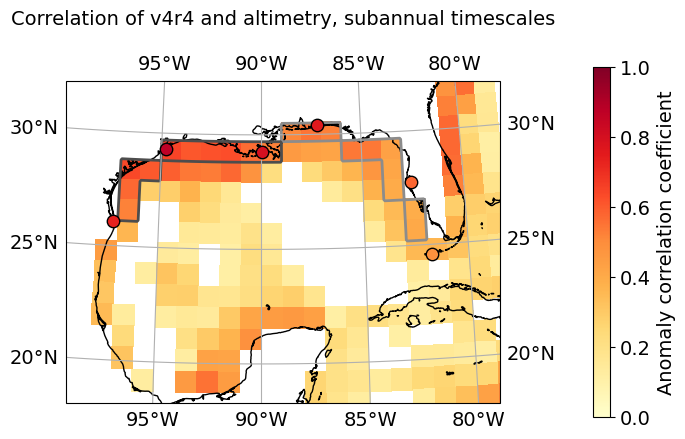

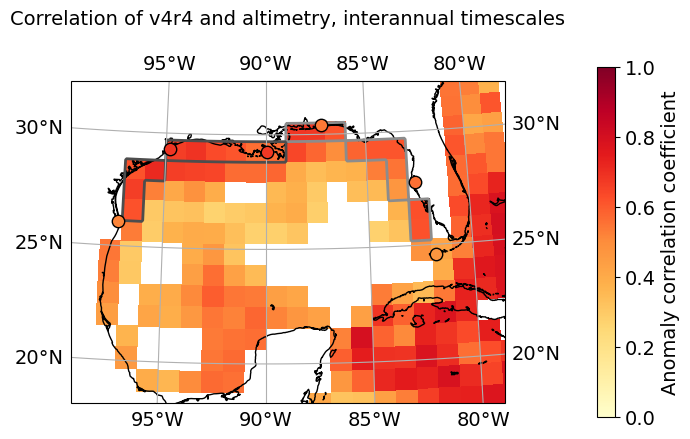

In [51]:
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ecco_v4_py as ecco

curr_proj = ccrs.Orthographic(central_longitude=270,\
                              central_latitude=25)

fig,ax = plt.subplots(1,1,figsize=(8,6.5),subplot_kw={'projection':curr_proj})
plt.rcParams.update({'font.size':14})
lon_centers_plot,lat_centers_plot,\
_,_,plot_EGC = ecco.resample_to_latlon(ds_grid.XC.values,ds_grid.YC.values,mask_EGC,\
                        new_grid_min_lat=17,new_grid_max_lat=33,new_grid_delta_lat=0.1,\
                        new_grid_min_lon=-100,new_grid_max_lon=-78,new_grid_delta_lon=0.1,\
                        mapping_method='nearest_neighbor')
ax.contour(lon_centers_plot,lat_centers_plot,\
                        plot_EGC,\
              transform=ccrs.PlateCarree(),levels=[0.5],colors=[(.55,.55,.55,1)],linewidths=2)
lon_centers_plot,lat_centers_plot,\
_,_,plot_WGC = ecco.resample_to_latlon(ds_grid.XC.values,ds_grid.YC.values,mask_WGC,\
                        new_grid_min_lat=17,new_grid_max_lat=33,new_grid_delta_lat=0.1,\
                        new_grid_min_lon=-100,new_grid_max_lon=-78,new_grid_delta_lon=0.1,\
                        mapping_method='nearest_neighbor')
ax.contour(lon_centers_plot,lat_centers_plot,\
                        plot_WGC,\
              transform=ccrs.PlateCarree(),levels=[0.5],colors=[(.3,.3,.3,1)],linewidths=2)
curr_plot = ax.pcolormesh(ds_grid.XG[:,12].values,ds_grid.YG[11,:].values,\
                          corr_subannual_plot.transpose(),\
                          cmap='YlOrRd',vmin=0,vmax=1,transform=ccrs.PlateCarree())
# plot tide gauges
for tgauge_count,place_id in enumerate(tidegauge_psmsl_id.keys()):
    ax.scatter(tidegauge_lon[place_id],tidegauge_lat[place_id],s=80,c=corr_subannual_at_tgauge[tgauge_count],\
                                   edgecolor=(0,0,0),cmap='YlOrRd',vmin=0,vmax=1,transform=ccrs.Geodetic(),zorder=3)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-99,-79,18,32],crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-95,-75,5))
gl.ylocator = mticker.FixedLocator(np.arange(20,35,5))
ax.set_title('Correlation of v4r4 and altimetry, subannual timescales\n',fontsize=14)
plt.colorbar(curr_plot,shrink=0.7,pad=0.15,label='Anomaly correlation coefficient')

plt.savefig('Corr_v4r4_altim_subannual_'+year_range_id+'.png')
plt.show()


fig,ax = plt.subplots(1,1,figsize=(8,6.5),subplot_kw={'projection':curr_proj})
plt.rcParams.update({'font.size':14})
lon_centers_plot,lat_centers_plot,\
_,_,plot_EGC = ecco.resample_to_latlon(ds_grid.XC.values,ds_grid.YC.values,mask_EGC,\
                        new_grid_min_lat=17,new_grid_max_lat=33,new_grid_delta_lat=0.1,\
                        new_grid_min_lon=-100,new_grid_max_lon=-78,new_grid_delta_lon=0.1,\
                        mapping_method='nearest_neighbor')
ax.contour(lon_centers_plot,lat_centers_plot,\
                        plot_EGC,\
              transform=ccrs.PlateCarree(),levels=[0.5],colors=[(.55,.55,.55,1)],linewidths=2)
lon_centers_plot,lat_centers_plot,\
_,_,plot_WGC = ecco.resample_to_latlon(ds_grid.XC.values,ds_grid.YC.values,mask_WGC,\
                        new_grid_min_lat=17,new_grid_max_lat=33,new_grid_delta_lat=0.1,\
                        new_grid_min_lon=-100,new_grid_max_lon=-78,new_grid_delta_lon=0.1,\
                        mapping_method='nearest_neighbor')
ax.contour(lon_centers_plot,lat_centers_plot,\
                        plot_WGC,\
              transform=ccrs.PlateCarree(),levels=[0.5],colors=[(.3,.3,.3,1)],linewidths=2)
curr_plot = ax.pcolormesh(ds_grid.XG[:,12].values,ds_grid.YG[11,:].values,\
                              corr_interannual_plot.transpose(),\
                              cmap='YlOrRd',vmin=0,vmax=1,transform=ccrs.PlateCarree())
# plot tide gauges
for tgauge_count,place_id in enumerate(tidegauge_psmsl_id.keys()):
    ax.scatter(tidegauge_lon[place_id],tidegauge_lat[place_id],s=80,c=corr_interannual_at_tgauge[tgauge_count],\
                                   edgecolor=(0,0,0),cmap='YlOrRd',vmin=0,vmax=1,transform=ccrs.Geodetic(),zorder=3)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-99,-79,18,32],crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-95,-75,5))
gl.ylocator = mticker.FixedLocator(np.arange(20,35,5))
ax.set_title('Correlation of v4r4 and altimetry, interannual timescales\n',fontsize=14)
plt.colorbar(curr_plot,shrink=0.7,pad=0.15,label='Anomaly correlation coefficient')

plt.savefig('Corr_v4r4_altim_interannual_'+year_range_id+'.png')
plt.show()

C:\Users\adelman\Documents\py_functions\filter_functions.py:230: RuntimeWarning: invalid value encountered in divide
  array_mean_2d = np.nansum(mask*input_array_2d,axis=0,keepdims=1)/mask_sum
C:\Users\adelman\Documents\py_functions\filter_functions.py:320: RuntimeWarning: invalid value encountered in divide
  dim_vec_nomean = dim_vec_tiled - (np.sum(mask*dim_vec_tiled,axis=0)/np.sum(mask,axis=0))
C:\Users\adelman\Documents\py_functions\filter_functions.py:321: RuntimeWarning: invalid value encountered in divide
  input_mean = np.nansum(mask*input_reshaped,axis=0,keepdims=True)/np.nansum(mask,axis=0,keepdims=True)
C:\Users\adelman\Documents\py_functions\filter_functions.py:325: RuntimeWarning: invalid value encountered in divide
  reg_trend = (np.moveaxis(reg_num/reg_denom,0,axis))/delta_dim


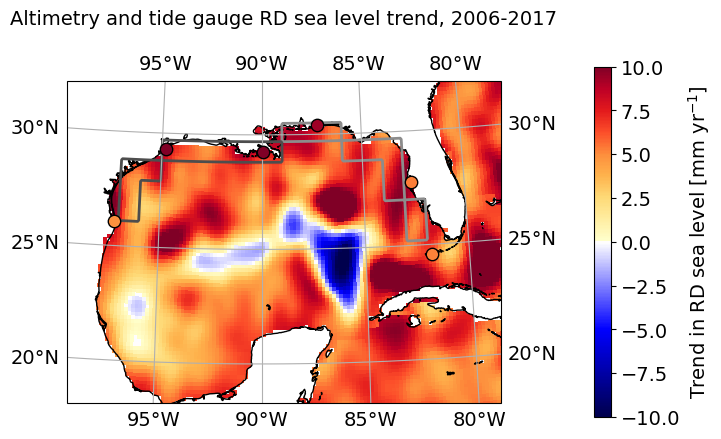

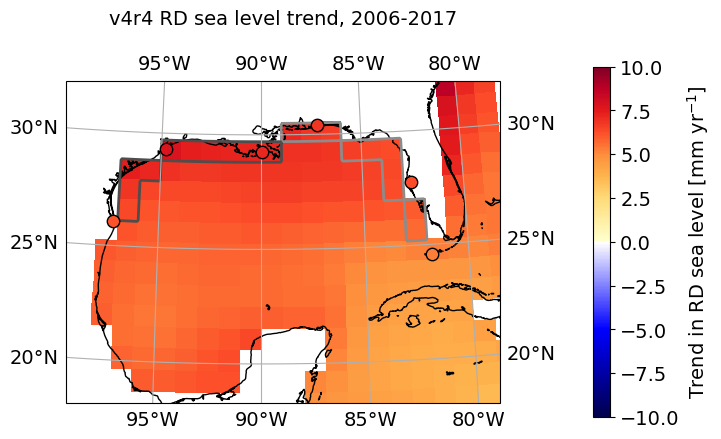

In [84]:
# show trend maps

trend_year_first = 2006
trend_year_last = 2017

plot_vmin = -10
plot_vmax = 10

trend_year_range_id = str(trend_year_first)+'_'+str(trend_year_last)

in_trend_range = np.logical_and(v4r4_time >= np.datetime64(str(trend_year_first)+'-01-01','ns'),\
                                v4r4_time < np.datetime64(str(trend_year_last+1)+'-01-01','ns')).nonzero()[0]

altim_noseas = seas_cycle_remove(SSH_rel_values_inrange,v4r4_time,time_axis_num=0)
trend_altim = trend_compute(altim_noseas[in_trend_range,:,:],axis=0,delta_dim=1/12).squeeze()

# trend_altim_llc90 = trend_compute(altim_llc90_noseas[in_trend_range,:,:],axis=0,delta_dim=1/12).squeeze()
trend_tgauge_all = trend_compute(tgauge_all_noseas[in_trend_range,:],axis=0,delta_dim=1/12).squeeze()
trend_v4r4 = trend_compute(v4r4_noseas[in_trend_range,:,:],axis=0,delta_dim=1/12).squeeze()
trend_v4r4_at_tgauge = trend_compute(v4r4_at_tgauge_noseas[in_trend_range,:],axis=0,delta_dim=1/12).squeeze()


import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ecco_v4_py as ecco

# create new colormap
curr_YlOrRd = mpl.colormaps['YlOrRd'](np.linspace(0,1,128))
curr_seismic = mpl.colormaps['seismic'](np.linspace(0,1,256))
curr_cmap = np.concatenate((curr_seismic[:129,:],curr_YlOrRd),axis=0)
curr_cmap = ListedColormap(curr_cmap)


curr_proj = ccrs.Orthographic(central_longitude=270,\
                              central_latitude=25)

fig,ax = plt.subplots(1,1,figsize=(8,6.5),subplot_kw={'projection':curr_proj})
plt.rcParams.update({'font.size':14})
lon_centers_plot,lat_centers_plot,\
_,_,plot_EGC = ecco.resample_to_latlon(ds_grid.XC.values,ds_grid.YC.values,mask_EGC,\
                        new_grid_min_lat=17,new_grid_max_lat=33,new_grid_delta_lat=0.1,\
                        new_grid_min_lon=-100,new_grid_max_lon=-78,new_grid_delta_lon=0.1,\
                        mapping_method='nearest_neighbor')
ax.contour(lon_centers_plot,lat_centers_plot,\
                        plot_EGC,\
              transform=ccrs.PlateCarree(),levels=[0.5],colors=[(.55,.55,.55,1)],linewidths=2)
lon_centers_plot,lat_centers_plot,\
_,_,plot_WGC = ecco.resample_to_latlon(ds_grid.XC.values,ds_grid.YC.values,mask_WGC,\
                        new_grid_min_lat=17,new_grid_max_lat=33,new_grid_delta_lat=0.1,\
                        new_grid_min_lon=-100,new_grid_max_lon=-78,new_grid_delta_lon=0.1,\
                        mapping_method='nearest_neighbor')
ax.contour(lon_centers_plot,lat_centers_plot,\
                        plot_WGC,\
              transform=ccrs.PlateCarree(),levels=[0.5],colors=[(.3,.3,.3,1)],linewidths=2)
tgauge_lon_min = np.nanmin(np.array([lon for lon in tidegauge_lon.values()]))
curr_plot = ax.pcolormesh(((SSH_rel.lon.values - (tgauge_lon_min - 180)) % 360) + (tgauge_lon_min - 180),\
                          SSH_rel.lat.values,\
                          (1.e3)*trend_altim,\
                          cmap=curr_cmap,vmin=plot_vmin,vmax=plot_vmax,transform=ccrs.PlateCarree())
# plot tide gauges
for tgauge_count,place_id in enumerate(tidegauge_psmsl_id.keys()):
    ax.scatter(tidegauge_lon[place_id],tidegauge_lat[place_id],s=80,c=(1.e3)*trend_tgauge_all[tgauge_count],\
                                   edgecolor=(0,0,0),cmap=curr_cmap,vmin=plot_vmin,vmax=plot_vmax,transform=ccrs.Geodetic(),zorder=3)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-99,-79,18,32],crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-95,-75,5))
gl.ylocator = mticker.FixedLocator(np.arange(20,35,5))
ax.set_title('Altimetry and tide gauge RD sea level trend, '+trend_year_range_id.replace('_','-')+'\n',fontsize=14)
plt.colorbar(curr_plot,shrink=0.7,pad=0.15,label='Trend in RD sea level [mm yr$^{-1}$]')

plt.savefig('Trend_map_altim_tgauge_'+trend_year_range_id+'.png')
plt.show()



fig,ax = plt.subplots(1,1,figsize=(8,6.5),subplot_kw={'projection':curr_proj})
plt.rcParams.update({'font.size':14})
lon_centers_plot,lat_centers_plot,\
_,_,plot_EGC = ecco.resample_to_latlon(ds_grid.XC.values,ds_grid.YC.values,mask_EGC,\
                        new_grid_min_lat=17,new_grid_max_lat=33,new_grid_delta_lat=0.1,\
                        new_grid_min_lon=-100,new_grid_max_lon=-78,new_grid_delta_lon=0.1,\
                        mapping_method='nearest_neighbor')
ax.contour(lon_centers_plot,lat_centers_plot,\
                        plot_EGC,\
              transform=ccrs.PlateCarree(),levels=[0.5],colors=[(.55,.55,.55,1)],linewidths=2)
lon_centers_plot,lat_centers_plot,\
_,_,plot_WGC = ecco.resample_to_latlon(ds_grid.XC.values,ds_grid.YC.values,mask_WGC,\
                        new_grid_min_lat=17,new_grid_max_lat=33,new_grid_delta_lat=0.1,\
                        new_grid_min_lon=-100,new_grid_max_lon=-78,new_grid_delta_lon=0.1,\
                        mapping_method='nearest_neighbor')
ax.contour(lon_centers_plot,lat_centers_plot,\
                        plot_WGC,\
              transform=ccrs.PlateCarree(),levels=[0.5],colors=[(.3,.3,.3,1)],linewidths=2)
curr_plot = ax.pcolormesh(ds_grid.XG[:,12].values,ds_grid.YG[11,:].values,\
                          (1.e3)*trend_v4r4.transpose(),\
                          cmap=curr_cmap,vmin=plot_vmin,vmax=plot_vmax,transform=ccrs.PlateCarree())
# plot tide gauges
for tgauge_count,place_id in enumerate(tidegauge_psmsl_id.keys()):
    ax.scatter(tidegauge_lon[place_id],tidegauge_lat[place_id],s=80,c=(1.e3)*trend_v4r4_at_tgauge[tgauge_count],\
                                   edgecolor=(0,0,0),cmap=curr_cmap,vmin=plot_vmin,vmax=plot_vmax,transform=ccrs.Geodetic(),zorder=3)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-99,-79,18,32],crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-95,-75,5))
gl.ylocator = mticker.FixedLocator(np.arange(20,35,5))
ax.set_title('v4r4 RD sea level trend, '+trend_year_range_id.replace('_','-')+'\n',fontsize=14)
plt.colorbar(curr_plot,shrink=0.7,pad=0.15,label='Trend in RD sea level [mm yr$^{-1}$]')

plt.savefig('Trend_map_v4r4_'+trend_year_range_id+'.png')
plt.show()